<a href="https://colab.research.google.com/github/DHjeelm/OpenProjectAboutGANs/blob/main/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate


In [2]:
# Load real Fashion images
def load_real_samples():
  # Load data
	(trainX, trainy), (_, _) = load_data()
  # Expand to 3D
	X = expand_dims(trainX, axis=-1)
  # Change type
	X = X.astype('float32')
	# Scale to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

In [3]:
# Generate real samples
def generate_real_samples(dataset, n_samples):

	# Split into images and labels
	images, labels = dataset

	# Fetch random instances
	ix = randint(0, images.shape[0], n_samples)
 
	# Select the images and labels
	X, labels = images[ix], labels[ix]

	# Generate class labels
	y = ones((n_samples, 1))
 
	return [X, labels], y

In [4]:
# Generate points in latent space to feed to the generator

def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# Generate points in the latent space
	x_input = randn(latent_dim * n_samples)
 
	# Reshape into a batch
	z_input = x_input.reshape(n_samples, latent_dim)
 
	# Generate labels
	labels = randint(0, n_classes, n_samples)
 
	return [z_input, labels]

In [5]:
# Use the generator to generate n fake examples
def generate_fake_samples(generator, latent_dim, n_samples):
  
	# Generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
 
	# Predict outputs
	images = generator.predict([z_input, labels_input])
 
	# Create class labels
	y = zeros((n_samples, 1))
 
	return [images, labels_input], y

In [6]:
# Define Discriminator

def define_discriminator(in_shape=(28,28,1), n_classes=10):

  # Model architechture
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	in_image = Input(shape=in_shape)
	merge = Concatenate()([in_image, li])
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)
	fe = Dropout(0.4)(fe)
	out_layer = Dense(1, activation='sigmoid')(fe)
 
	# Create model
	model = Model([in_image, in_label], out_layer)
 
	# Compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 
	return model

In [7]:
# Define Generator

def define_generator(latent_dim, n_classes=10):

  # Model architechture
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	li = Reshape((7, 7, 1))(li)
	in_lat = Input(shape=(latent_dim,))
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	merge = Concatenate()([gen, li])
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
 
	# Create model
	model = Model([in_lat, in_label], out_layer)
	return model

In [8]:
# Define the GAN
def define_gan(g_model, d_model):
	# Make weights in the discriminator not trainable
	d_model.trainable = False

	# Fetch noise and label inputs from generator model
	gen_noise, gen_label = g_model.input

	# Fetch image output from the generator model
	gen_output = g_model.output

	# Connect the generator and the discriminator
	gan_output = d_model([gen_output, gen_label])
 
	# Define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
 
	# Compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [9]:
# Training

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):

  # Batches
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
 
	# Iterate over epochs
	for i in range(n_epochs):
		# Iterate over batches
		for j in range(bat_per_epo):
    
			# Fetch randomly selected reals samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
   
			# Train discriminator model on batch
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
   
			# Generate fake examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
   
			# Train discriminator model on batch
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
   
			# Generate points in latent space to feed to generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
   
			# Create inverted labels (fake samples)
			y_gan = ones((n_batch, 1))
   
			# Use discriminator feedback to update the generator
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
   
			# Summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# Save the generator model
	g_model.save('cgan_generator.h5')

In [10]:
# Running all the code 

# Define latent space size
latent_dim = 100

# Create the discriminator
d_model = define_discriminator()

# Create the generator
g_model = define_generator(latent_dim)

# Create the gan
gan_model = define_gan(g_model, d_model)

# Load image data
dataset = load_real_samples()

# Train
train(g_model, d_model, gan_model, dataset, latent_dim)

40960/29515 [=========================================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Utdata för streaming har trunkerats till de sista 5000 raderna.
>90, 150/468, d1=0.669, d2=0.666 g=0.777
>90, 151/468, d1=0.627, d2=0.682 g=0.745
>90, 152/468, d1=0.676, d2=0.686 g=0.750
>90, 153/468, d1=0.672, d2=0.660 g=0.756
>90, 154/468, d1=0.672, d2=0.701 g=0.781
>90, 155/468, d1=0.713, d2=0.670 g=0.763
>90, 156/468, d1=0.658, d2=0.638 g=0.768
>90, 157/468, d1=0.708, d2=0.651 g=0.742
>90, 158/468, d1=0.684, d2=0.661 g=0.765
>90, 159/468, d1=0.681, d2=0.668 g=0.773
>90, 160/468, d1=0.681, d2=0.678 g=0.757
>90, 161/468, d1=0.706, d2=0.710 g=0.771
>90, 162/468, d1=0.646, d2=0.685 g=0.782
>90, 163/468, d1=0.706, d2=0.652 g=0.775
>90, 164/468, d1=0.699, d2=0.661 g=0.778
>90, 165/468, d1=0.689, d2=0.660 g=0.774
>90, 166/468, d1=0.706, d2=0.689 g=0.756
>90, 167/468, d1=0.653, d2=0.644 g=0.786
>90, 168/468, d1=0.681, d2=0.686 g=0.748
>90, 169/468, d1=0.657, d2=0.728 g=0.741
>90, 170/468, d1=0.686, d2=0.706 g=0.762
>90, 171/468, d1=0.702, d2=0.682 g=0.791
>90, 172/468, d1=0.719, d2=0.707 g

In [13]:
# Create and save a plot of generated images
from matplotlib import pyplot

def save_plot(examples, n):

	for i in range(n * n):
	
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  
	pyplot.show()

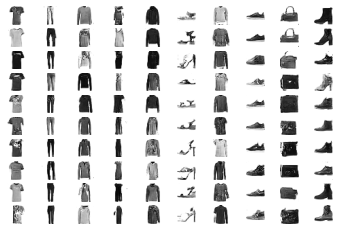

In [15]:
from keras.models import load_model
from numpy import asarray

# Load model
model = load_model('cgan_generator.h5')
# Generate images
latent_points, labels = generate_latent_points(100, 100)
# Specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# Generate images
X  = model.predict([latent_points, labels])
# Scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# Plot the result
save_plot(X, 10)